In [1]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
# Define dataset and data loaders for training and validation
train_dataset = ImageFolder('C:/Users/vaish/MSBA Files/Advanced Machine Learning/AML Project/chest_xray_reshuffle/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataset = ImageFolder('C:/Users/vaish/MSBA Files/Advanced Machine Learning/AML Project/chest_xray_reshuffle/val', transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32)

### ResNet

In [4]:
# Initialize a DenseNet model (e.g., DenseNet-121)
model = models.densenet121(pretrained=True)

# Modify the output layer to match your binary classification task
num_features = model.classifier.in_features  # For DenseNet-121, use 'classifier' instead of 'fc'
dropout_rate = 0.5  # Set your desired dropout rate
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(num_features, 2)  # 2 output classes (pneumonia present or not)
)

C:\Users\vaish\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vaish\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a function for training the model
def train_model(model, train_loader, criterion, optimizer, validation_loader, num_epochs=50):
    train_accuracy_list = []
    validation_accuracy_list = []
    validation_precision_list = []
    validation_recall_list = []
    validation_f1_list = []
    validation_auc_list = []
    validation_auc_pr_list = []
    validation_loss_list = []
    train_loss_list = []

    for epoch in range(num_epochs):
        print("Epoch", epoch)
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(total_loss/len(train_loader))  # Store training loss
        
        # Print and store training accuracy
        print(f'Training - Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {train_accuracy}%')

        # Validation loop
        validation_accuracy, validation_loss, precision, recall, f1, auc, auc_pr = test_model(model, validation_loader)
        validation_accuracy_list.append(validation_accuracy)
        validation_loss_list.append(validation_loss)  # Store validation loss
        validation_precision_list.append(precision)
        validation_recall_list.append(recall)
        validation_f1_list.append(f1)
        validation_auc_list.append(auc)
        validation_auc_pr_list.append(auc_pr)
        
        # Save the model after each epoch
        # torch.save(model.state_dict(), save_path.format(epoch+1))

        # Print and store validation metrics
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Loss: {validation_loss:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Accuracy: {validation_accuracy:.2f}%')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Precision: {precision:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, Recall: {recall:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, F1 Score: {f1:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, AUC: {auc:.4f}')
        print(f'Validation - Epoch {epoch + 1}/{num_epochs}, AUC-PR: {auc_pr:.4f}')

    return train_accuracy_list, validation_accuracy_list, train_loss_list, validation_loss_list, validation_precision_list, validation_recall_list, validation_f1_list, validation_auc_list, validation_auc_pr_list



def test_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    total_loss = 0.0  # Added for validation loss

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Calculate validation loss
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save predictions and true labels
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    accuracy = 100 * correct / total
    average_loss = total_loss / len(data_loader)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, predictions)
    auc_pr = average_precision_score(true_labels, predictions)

    return accuracy, average_loss, precision, recall, f1, auc, auc_pr

In [7]:
train_accuracy_per_epoch, validation_accuracy_per_epoch, train_loss_per_epoch, validation_loss_per_epoch, validation_precision_per_epoch, validation_recall_per_epoch, validation_f1_per_epoch, validation_auc_per_epoch, validation_auc_pr_per_epoch = train_model(model, train_loader, criterion, optimizer, validation_loader, num_epochs=50)

Epoch 0
Training - Epoch 1/50, Loss: 0.05777951020297601, Accuracy: 98.07938540332907%
Validation - Epoch 1/50, Loss: 0.3248
Validation - Epoch 1/50, Accuracy: 91.11%
Validation - Epoch 1/50, Precision: 0.9085
Validation - Epoch 1/50, Recall: 0.9766
Validation - Epoch 1/50, F1 Score: 0.9413
Validation - Epoch 1/50, AUC: 0.8554
Validation - Epoch 1/50, AUC-PR: 0.9043
Epoch 1
Training - Epoch 2/50, Loss: 0.07860416424109087, Accuracy: 97.01237729406743%
Validation - Epoch 2/50, Loss: 0.3322
Validation - Epoch 2/50, Accuracy: 90.26%
Validation - Epoch 2/50, Precision: 0.8838
Validation - Epoch 2/50, Recall: 0.9977
Validation - Epoch 2/50, F1 Score: 0.9373
Validation - Epoch 2/50, AUC: 0.8216
Validation - Epoch 2/50, AUC-PR: 0.8835
Epoch 2
Training - Epoch 3/50, Loss: 0.045753267336301, Accuracy: 98.39948783610755%
Validation - Epoch 3/50, Loss: 0.2535
Validation - Epoch 3/50, Accuracy: 92.65%
Validation - Epoch 3/50, Precision: 0.9174
Validation - Epoch 3/50, Recall: 0.9883
Validation - E

Training - Epoch 23/50, Loss: 0.01241596420069462, Accuracy: 99.53051643192488%
Validation - Epoch 23/50, Loss: 0.3710
Validation - Epoch 23/50, Accuracy: 92.99%
Validation - Epoch 23/50, Precision: 0.9347
Validation - Epoch 23/50, Recall: 0.9719
Validation - Epoch 23/50, F1 Score: 0.9529
Validation - Epoch 23/50, AUC: 0.8942
Validation - Epoch 23/50, AUC-PR: 0.9289
Epoch 23
Training - Epoch 24/50, Loss: 0.012790778115664753, Accuracy: 99.48783610755441%
Validation - Epoch 24/50, Loss: 0.4535
Validation - Epoch 24/50, Accuracy: 92.65%
Validation - Epoch 24/50, Precision: 0.9192
Validation - Epoch 24/50, Recall: 0.9859
Validation - Epoch 24/50, F1 Score: 0.9514
Validation - Epoch 24/50, AUC: 0.8759
Validation - Epoch 24/50, AUC-PR: 0.9166
Epoch 24
Training - Epoch 25/50, Loss: 0.0036473874498740145, Accuracy: 99.8719590268886%
Validation - Epoch 25/50, Loss: 0.4538
Validation - Epoch 25/50, Accuracy: 93.33%
Validation - Epoch 25/50, Precision: 0.9236
Validation - Epoch 25/50, Recall: 0.

Training - Epoch 45/50, Loss: 0.014448568779164284, Accuracy: 99.59453691848059%
Validation - Epoch 45/50, Loss: 0.5024
Validation - Epoch 45/50, Accuracy: 91.45%
Validation - Epoch 45/50, Precision: 0.9036
Validation - Epoch 45/50, Recall: 0.9883
Validation - Epoch 45/50, F1 Score: 0.9441
Validation - Epoch 45/50, AUC: 0.8517
Validation - Epoch 45/50, AUC-PR: 0.9016
Epoch 45
Training - Epoch 46/50, Loss: 0.01272818853294202, Accuracy: 99.61587708066581%
Validation - Epoch 46/50, Loss: 0.2950
Validation - Epoch 46/50, Accuracy: 94.87%
Validation - Epoch 46/50, Precision: 0.9441
Validation - Epoch 46/50, Recall: 0.9883
Validation - Epoch 46/50, F1 Score: 0.9657
Validation - Epoch 46/50, AUC: 0.9150
Validation - Epoch 46/50, AUC-PR: 0.9416
Epoch 46
Training - Epoch 47/50, Loss: 0.0206765859882311, Accuracy: 99.35979513444302%
Validation - Epoch 47/50, Loss: 0.3236
Validation - Epoch 47/50, Accuracy: 94.02%
Validation - Epoch 47/50, Precision: 0.9336
Validation - Epoch 47/50, Recall: 0.98

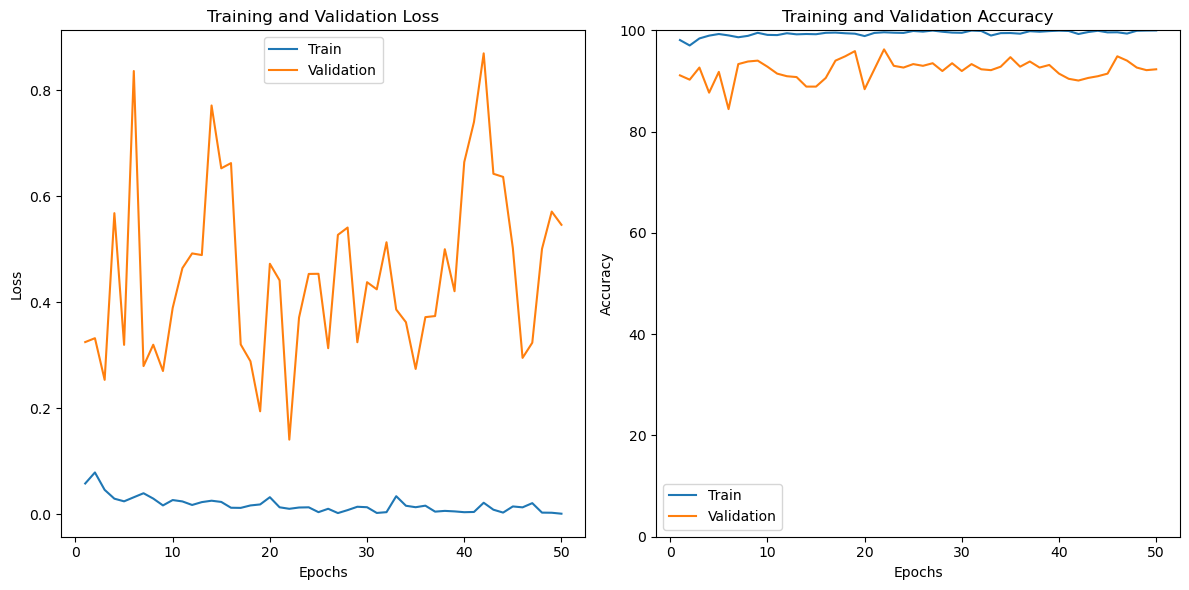

In [8]:
import matplotlib.pyplot as plt
import numpy as np

num_epochs=50
# Assuming you have the following lists
epochs = np.arange(1, num_epochs + 1)
train_loss = train_loss_per_epoch
validation_loss = validation_loss_per_epoch
train_accuracy = train_accuracy_per_epoch
validation_accuracy = validation_accuracy_per_epoch

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, validation_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train')
plt.plot(epochs, validation_accuracy, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [9]:
# Create a DataFrame for training accuracy
train_epoch_list = list(range(1, len(train_accuracy_per_epoch) + 1))
train_df = pd.DataFrame({'Epoch': train_epoch_list, 'Train Accuracy': train_accuracy_per_epoch})

# Display the training DataFrame
print(train_df)

# Save the training accuracy DataFrame to a CSV file
train_df.to_csv('train_accuracy_results_resnet18_0.1_32_10_false.csv', index=False)

# Create a DataFrame for validation accuracy
val_epoch_list = list(range(1, len(validation_accuracy_per_epoch) + 1))
val_df = pd.DataFrame({'Epoch': val_epoch_list, 'Validation Accuracy': validation_accuracy_per_epoch})

# Display the validation DataFrame
print(val_df)

    Epoch  Train Accuracy
0       1       98.079385
1       2       97.012377
2       3       98.399488
3       4       98.954332
4       5       99.274434
5       6       98.997012
6       7       98.634230
7       8       98.911652
8       9       99.509176
9      10       99.103713
10     11       99.061033
11     12       99.423816
12     13       99.210414
13     14       99.274434
14     15       99.231754
15     16       99.509176
16     17       99.551857
17     18       99.423816
18     19       99.338455
19     20       98.868971
20     21       99.487836
21     22       99.615877
22     23       99.530516
23     24       99.487836
24     25       99.871959
25     26       99.743918
26     27       99.957320
27     28       99.722578
28     29       99.551857
29     30       99.509176
30     31       99.957320
31     32       99.871959
32     33       98.975672
33     34       99.445156
34     35       99.466496
35     36       99.338455
36     37       99.829279
37     38   

In [10]:
# Save the validation accuracy DataFrame to a CSV file
val_df.to_csv('val_accuracy_results_densenet121_0.001_32_50_true.csv', index=False)

In [11]:
torch.save(model.state_dict(), 'densenet121_model_weights_0.001_32_50_true.pth')

In [12]:
# Define a data loader for the test set
test_dataset = ImageFolder('C:/Users/vaish/MSBA Files/Advanced Machine Learning/AML Project/chest_xray/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

In [14]:
# Test the model on the test set
test_accuracy, test_average_loss, precision, recall, f1, auc, auc_pr = test_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'AUC-PR: {auc_pr:.4f}')

Test Accuracy: 77.24%
Precision: 0.7331
Recall: 1.0000
F1 Score: 0.8460
AUC: 0.6966
AUC-PR: 0.7331


In [15]:
test_df = pd.DataFrame({
    'Test Accuracy': [test_accuracy]
})
test_df.to_csv('test_accuracy_results_densenet121_0.001_32_50_true.csv', index=False)

Testing saved model on test set

In [32]:
# Load the saved model weights
model.load_state_dict(torch.load('resnet18_model_weights_0.1_32_18_true.pth'))

<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')